In [13]:
import numpy as np
import pandas as pd
import linearsolve as ls
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize
plt.style.use('classic')
%matplotlib inline
font = {'size'   : 22}

plt.rc('font', **font)

In [14]:
class DSGE_simple_economy(): #economical system with all the properties
    
    def __init__(self):

        self.alpha = 0.2  #model default parameters
        self.beta = 0.995
        self.gamma = 0.2
        self.delta = 0.5
        self.k = 1 - self.beta
        self.rho_g = 0.1
        self.rho_u = 0.1
        self.pibar = 0.53717
        self.rbar = -np.log(self.beta)
        self.ybar = 0
        self.state = [0, self.pibar, self.rbar, 0, 0]
        self.i = self.pibar+self.rbar
        self.pi = self.pibar
        self.y = 0
        self.r = self.rbar
        self.gt = 0
        self.ut = 0
    
    def AR_1_shock(self, rho, val): #technical function to produce random AR(1) shocks
        
        mu, sigma = 0, 0.0001
        s = np.random.normal(mu, sigma)
        return rho*val + s
    
    def reset(self): #reset the system to the default state
        
        self.alpha = 0.2 
        self.beta = 0.995
        self.gamma = 0.2
        self.delta = 0.5
        self.k = 1 - self.beta
        self.rho_g = 0.1
        self.rho_u = 0.1
        self.pibar = 0.53717
        self.rbar = -np.log(self.beta)
        self.ybar = 0
        self.state = [0, self.pibar, self.rbar, 0, 0]
        self.i = self.pibar+self.rbar
        self.pi = self.pibar
        self.y = 0
        self.r = self.rbar
        self.gt = 0
        self.ut = 0
        
    
    def transition(self, step, shock = None):  #transist the system to the next step 
    
        self.gt = self.AR_1_shock(self.rho_g, self.state[3])
        self.ut = self.AR_1_shock(self.rho_u, self.state[4])

        denom = (1 + self.alpha*(-1 + self.beta*self.gamma) - self.gamma*(self.beta + self.k))

        self.pi = (self.k*(self.gt - 200*self.i + self.pibar - self.gamma*self.pibar + self.rbar) + (-1 + self.alpha)*((-1 + self.beta*self.gamma)*self.pibar - self.ut))/ denom
        self.pi = self.state[1]*8/9+ self.pi/9
        self.r = self.i - 2*self.gamma*self.pi - (1-self.gamma)*self.pibar
        self.y = (1-self.alpha)*self.ybar - (self.r - self.rbar) + self.gt
        self.y = self.state[0]*4/5+ self.y/5

        if shock != None:       #introduce shocks
            if step in shock[0]:
                if shock[1]== "inflation":
                    self.pi += 0.05
                    #print("done")

        self.state = [self.y, self.pi, self.r, self.gt, self.ut]
        
        pass
        
    
    def simple_policy_full(self, repeats, periods, policy, shock): #function to simulate full economic cycle with simple linear or w/o policy
        
        loss_vec = []
        self.state = [0, self.pibar, self.rbar, 0, 0]
        self.i = self.pibar+self.rbar

        for i in range(repeats):

            loss = 0
            vec_output = []
            vec_inflation = []
            vec_real_rate = []
            vec_cb_rate = []

            for step in range(periods):

                self.transition(step, shock)
                vec_output.append(self.state[0])
                vec_inflation.append(self.state[1])
                vec_real_rate.append(self.state[2])
                vec_cb_rate.append(self.i)

                proc_dev_pi = (self.state[1] - self.pibar) / self.pibar
                proc_dev_r = (self.state[2] - self.rbar) / self.rbar

                if policy == True:
                    self.i = (self.pibar+self.rbar) * (1+proc_dev_pi/2)

                loss += (self.state[1] - self.pibar)**2 + (self.state[0] - self.ybar)**2
            loss_vec.append(loss)

        return vec_output, vec_inflation, vec_real_rate, vec_cb_rate, loss_vec
    
    def plot_policy(self, type_, shock, periods, vec_output = None, vec_inflation= None, vec_real_rate= None, vec_cb_rate= None, loss_vec= None): #produce the plot from the sequences of data
        
        if type_ == 'simple':
            vec_output, vec_inflation, vec_real_rate, vec_cb_rate, loss_vec = self.simple_policy_full(repeats = 1, periods = periods, policy=True, shock = shock)
        if type_ == 'no':
            vec_output, vec_inflation, vec_real_rate, vec_cb_rate, loss_vec = self.simple_policy_full(repeats = 1, periods = periods, policy=False, shock = shock)
        if type_ == 'def':
            pass
        
        low = 75
        high = 150
        print("Loss = ", np.mean(loss_vec))
        #print("Average = ", np.mean(vec_real_rate[-50:]))
        
        print("Av Y " , np.mean(vec_output[-50:]))
        print("Av pi " ,np.mean(vec_inflation[-50:]))
        print("Av r " , np.mean(vec_real_rate[-50:]))
        print("Av i " , np.mean(vec_cb_rate[-50:]))
              
        

        fig, axs = plt.subplots(2, 2)
        plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
        axs[0, 0].plot(vec_output[low:high])
        axs[0, 0].set_title('Output')
        axs[0, 1].plot(vec_inflation[low:high], 'tab:orange')
        axs[0, 1].set_title('Inflation')
        axs[1, 0].plot(vec_real_rate[low:high], 'tab:green')
        axs[1, 0].set_title('Real rate')
        axs[1, 1].plot(vec_cb_rate[low:high], 'tab:red')
        axs[1, 1].set_title('CB rate')
        for ax in axs.flat:
            ax.set(xlabel='time period', ylabel='value; normal scale')
            ax.get_yaxis().set_visible(False)
                
        
    

In [15]:
economy = DSGE_simple_economy()

Loss =  47.47193896575033
Av Y  0.15675945480965695
Av pi  0.06580878174525094
Av r  -0.15175686032139482
Av i  0.30430265237670556


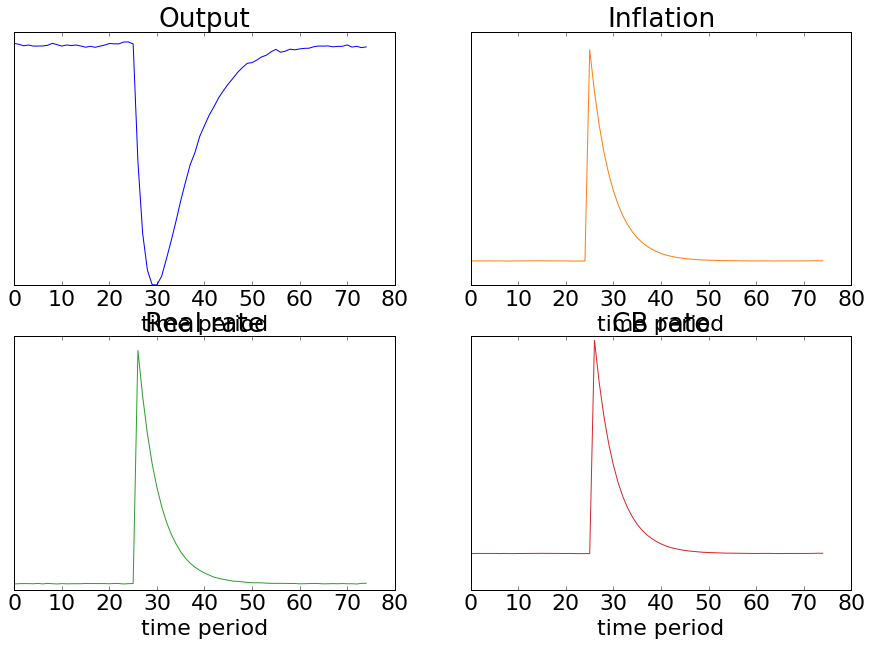

In [16]:
plt.rcParams["figure.figsize"] = (15,10)
economy.plot_policy(type_ = 'simple', shock = [[100], 'inflation'], periods = 200)

Loss =  142.16602500290637
Av Y  -0.2298069939894085
Av pi  -0.3060120250951794
Av r  0.234851351861616
Av i  0.5421825418235442


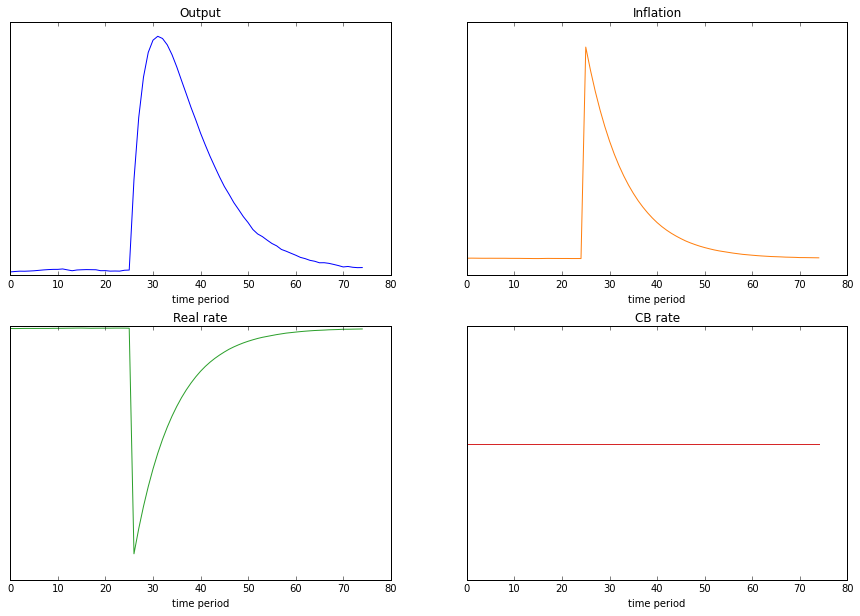

In [5]:
plt.rcParams["figure.figsize"] = (15,10)
economy.plot_policy(type_ = 'no', shock = [[100], 'inflation'], periods = 200)

In [6]:
class MPC():
    def __init__(self):
        
        self.system = DSGE_simple_economy()
        self.step = 0
        self.out_seen = []
        self.pi_seen = []
        self.r_seen = []
        self.i_set = []
        self.shock = False
        self.left = 0
        self.intercept_pi = 0
        self.slope_pi = 0
        self.mu, self.sigma = 0, 0.001
        self.intercept_out = 0
        self.slope_out = 0
        self.system.i = 0.7692
        
#     def cost(self):
#         cost = 0
#         for i in self.out_seen:
#             cost += (i-self.system.ybar)**2+(self.pi_seen[i]-self.system.pibar)**2
#         return cost
    
    def reset(self):
        self.system = DSGE_simple_economy()
        self.step = 0
        self.out_seen = []
        self.pi_seen = []
        self.r_seen = []
        self.i_set = []
        self.shock = False
        self.left = 0
        self.mu, self.sigma = 0, 0.001
        self.system.i = 0.7692
        
            
    def train_responce_estimator(self, steps = 200, shock = [[75, 125, 175], 'inflation'], policy = True):
        
        self.reset()
        
        
        
        self.step = 0
        self.system.reset()
        intercepts = 0
        slopes = 0
        counter = 0
        intercepts_1 = 0 
        slopes_1 = 0
        counter_1 = 0
        intercepts_2 = 0 
        slopes_2 = 0
        
        
        for i in range(steps):
            
            self.left = max(0, self.left-1)
            if self.left ==0:
                self.shock = False
                
            self.out_seen.append(self.system.state[0])
            self.pi_seen.append(self.system.state[1])
            self.r_seen.append(self.system.state[2])
            
            proc_dev_pi = (self.system.state[1] - self.system.pibar) / self.system.pibar
            
            if policy == True:
                    self.system.i = (self.system.pibar+self.system.rbar) * (1+proc_dev_pi) + np.random.normal(self.mu, self.sigma)
            
            self.i_set.append(self.system.i)
            #print(self.pi_seen, self.i_set)
            
            
            
            if i in shock[0]:
                self.shock = True
                self.left = 10
                
            if self.shock == True:
                reg = LinearRegression().fit(np.array(self.i_set[i-5:i]).reshape(-1, 1), self.pi_seen[i-5:i])
            
                intercepts += reg.intercept_ 
                slopes += reg.coef_
                counter += 1
                
                reg_1 = LinearRegression().fit(np.array(self.i_set[i-5:i]).reshape(-1, 1), self.out_seen[i-5:i])
            
                intercepts_1 += reg_1.intercept_ 
                slopes_1 += reg_1.coef_
                
                reg_2 = LinearRegression().fit(np.array(self.pi_seen[i-6:i-1]).reshape(-1, 1), self.pi_seen[i-5:i])
                intercepts_2 += reg_2.intercept_ 
                slopes_2 += reg_2.coef_

            self.system.transition(step = i, shock = shock)
            #[self.y, self.pi, self.r, self.gt, self.ut]
            
        self.intercept_pi = intercepts / counter
        self.slope_pi = slopes[0] / counter
        
        self.intercept_out = intercepts_1 / counter
        self.slope_out = slopes_1[0] / counter
        
        self.intercept_pi_s = intercepts_2 / counter
        self.slope_pi_s = slopes_2[0] / counter
        
        #print(self.intercept_pi_s,self.slope_pi_s )
        
        
    def train_control(self, steps, horizon, shock = [[100], 'inflation']):
        
        self.train_responce_estimator(steps = 200, policy = True)
        self.reset()
        self.system.reset()
        self.loss = 0
        self.i = 0.7692
        
        for i in range(steps):
            
            self.out_seen.append(self.system.state[0])
            self.pi_seen.append(self.system.state[1])
            self.r_seen.append(self.system.state[2])
            
            proc_dev_pi = (self.system.state[1] - self.system.pibar) / self.system.pibar
            self.system.i = (self.system.pibar+self.system.rbar) * (1+proc_dev_pi)
            
                
            self.predict_pi_self = self.intercept_pi_s*self.system.state[1] + self.slope_pi_s
            
            #if self.system.state[1] > np.mean(self.pi_seen[i-10:i]) and i > 12:
            self.system.i = self.minimizer()
            self.i_set.append(self.system.i)
            
            self.loss += (self.system.state[0] - self.system.ybar)**2 + (self.system.state[1] - self.system.pibar)**2
            self.system.transition(step = i, shock = shock)
            
        
        self.system.plot_policy(type_ = None, shock=None, periods=200, vec_output = self.out_seen, vec_inflation= self.pi_seen, vec_real_rate= self.r_seen, vec_cb_rate= self.i_set, loss_vec= self.loss)
        #print(self.system.pibar+self.system.rbar)
                       
    def minimizer(self):
    
        i = (self.system.rbar+self.system.pibar - self.slope_pi * self.intercept_pi - self.slope_out * self.intercept_out)/ (self.slope_pi**2 +  self.slope_out **2)  + 1.2* (self.system.state[1] - self.system.pibar) / self.system.pibar
        return i
        
    def adapter(self, a, b):
        return (a - b)/b

        
                
            
            
            
        



Loss =  40.23325386179836
Av Y  0.3800072388466518
Av pi  0.280461415807861
Av r  -0.3749739790790037
Av i  0.16694458454669106


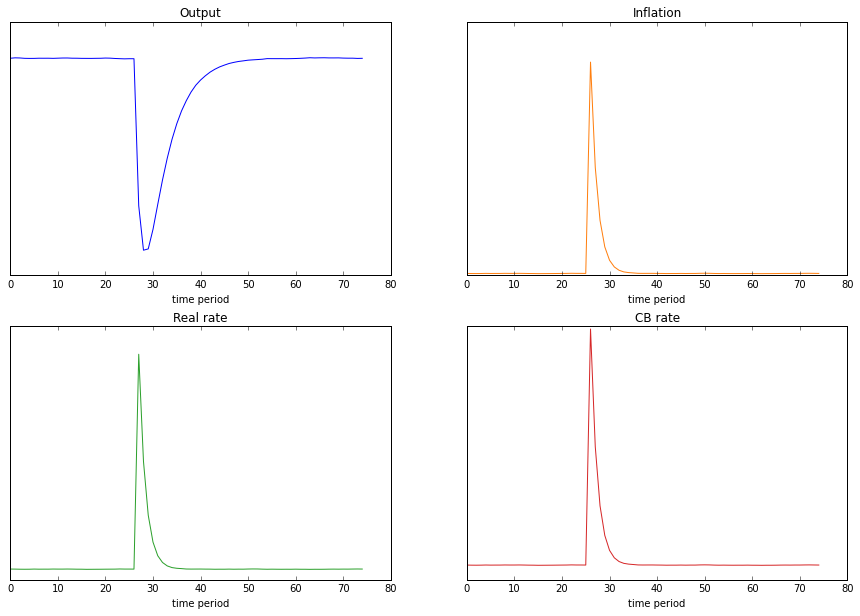

In [7]:
control = MPC()
control.train_control(steps = 200, horizon = 3, shock = [[100], 'inflation'])